In [2]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
from statsmodels.datasets import get_rdataset
import sklearn.model_selection as skm
from ISLP import load_data , confusion_table
from ISLP.models import ModelSpec as MS

In [ ]:
from sklearn.tree import (DecisionTreeClassifier as DTC,
                        DecisionTreeRegressor as DTR,
                        plot_tree,
                        export_text)
from sklearn.metrics import (accuracy_score,
                            log_loss)
from sklearn.ensemble import \
    (RandomForestRegressor as RF,
    GradientBoostingRegressor as GBR)
from ISLP.bart import BART

## Fitting Classification tree

In [5]:
Carseats = load_data('Carseats')
High = np.where(Carseats.Sales > 8,
            "Yes",
            "No")

In [79]:
model = MS(Carseats.columns.drop('Sales'), intercept=False)
D = model.fit_transform(Carseats)
feature_names = list(D.columns)
X = np.asarray(D)

In [9]:
clf = DTC(criterion='entropy',
        max_depth=3,
        random_state=0)
clf.fit(X, High)

DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0)

In [11]:
accuracy_score(High , clf.predict(X))

0.79

In [13]:
resid_dev = np.sum(log_loss(High , clf.predict_proba(X)))
resid_dev

0.4710647062649358

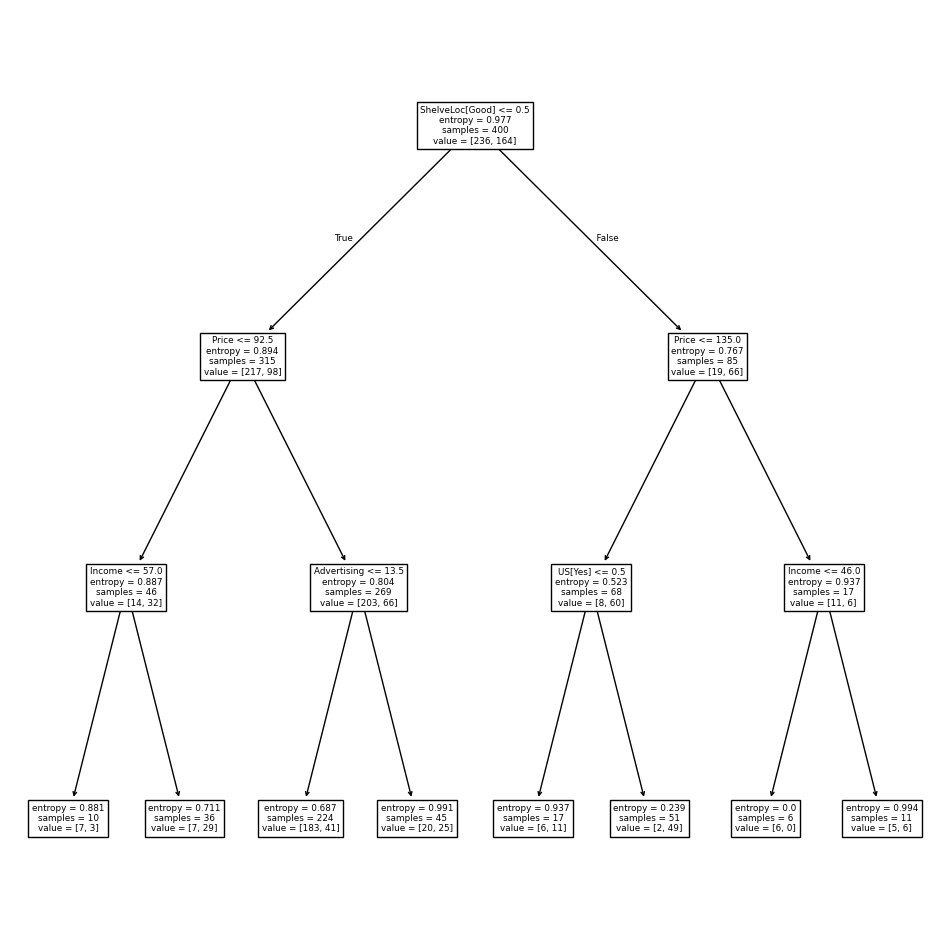

In [15]:
ax = subplots(figsize=(12,12))[1]
plot_tree(clf ,
        feature_names=feature_names ,
        ax=ax);

In [17]:
print(export_text(clf ,
                feature_names=feature_names ,
                show_weights=True))

|--- ShelveLoc[Good] <= 0.50
|   |--- Price <= 92.50
|   |   |--- Income <= 57.00
|   |   |   |--- weights: [7.00, 3.00] class: No
|   |   |--- Income >  57.00
|   |   |   |--- weights: [7.00, 29.00] class: Yes
|   |--- Price >  92.50
|   |   |--- Advertising <= 13.50
|   |   |   |--- weights: [183.00, 41.00] class: No
|   |   |--- Advertising >  13.50
|   |   |   |--- weights: [20.00, 25.00] class: Yes
|--- ShelveLoc[Good] >  0.50
|   |--- Price <= 135.00
|   |   |--- US[Yes] <= 0.50
|   |   |   |--- weights: [6.00, 11.00] class: Yes
|   |   |--- US[Yes] >  0.50
|   |   |   |--- weights: [2.00, 49.00] class: Yes
|   |--- Price >  135.00
|   |   |--- Income <= 46.00
|   |   |   |--- weights: [6.00, 0.00] class: No
|   |   |--- Income >  46.00
|   |   |   |--- weights: [5.00, 6.00] class: Yes



In [19]:
validation = skm.ShuffleSplit(n_splits=1,
                            test_size=200,
                            random_state=0)
results = skm.cross_validate(clf ,
                            D,
                            High,
                            cv=validation)
results['test_score']

array([0.685])

In [21]:
(X_train ,
X_test ,
High_train ,
High_test) = skm.train_test_split(X,
                                High,
                                test_size=0.5,
                                random_state=0)

In [23]:
clf = DTC(criterion='entropy', random_state=0)
clf.fit(X_train , High_train)
accuracy_score(High_test , clf.predict(X_test))

0.735

In [25]:
ccp_path = clf.cost_complexity_pruning_path(X_train , High_train)
kfold = skm.KFold(10,
                random_state=1,
                shuffle=True)

In [27]:
grid = skm.GridSearchCV(clf ,
                        {'ccp_alpha': ccp_path.ccp_alphas},
                        refit=True,
                        cv=kfold ,
                        scoring='accuracy')
grid.fit(X_train , High_train)
grid.best_score_

0.685

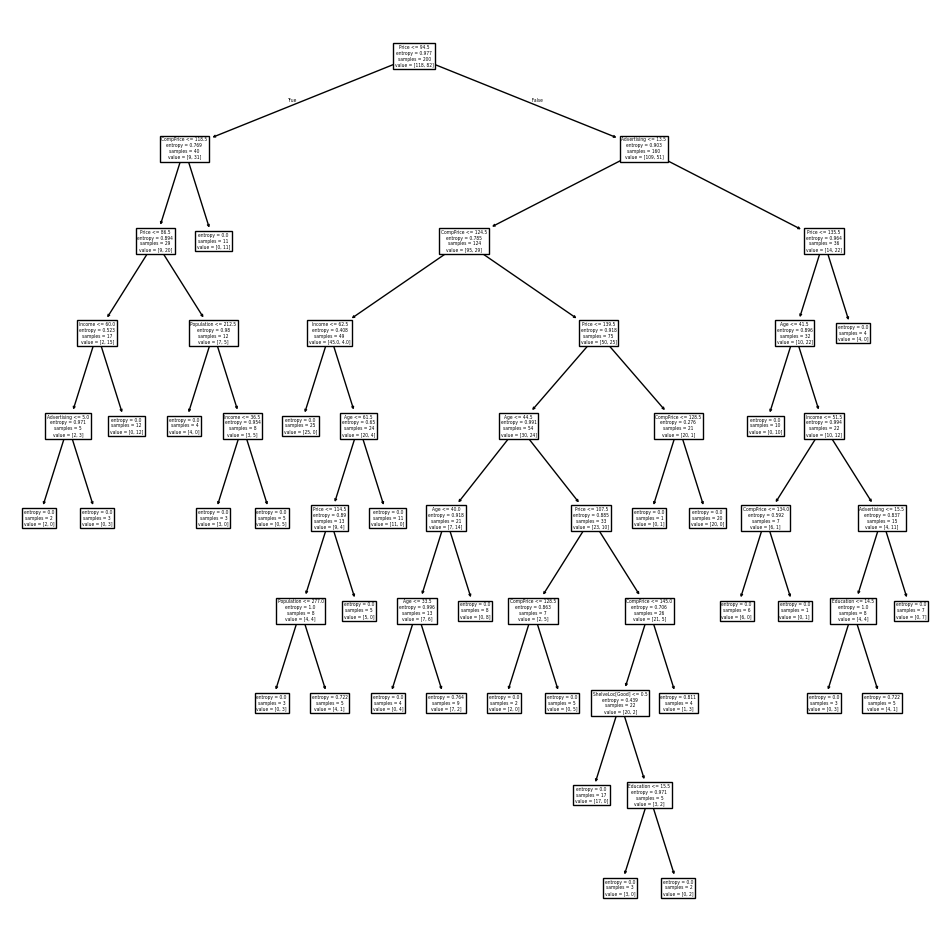

In [29]:
ax = subplots(figsize=(12, 12))[1]
best_ = grid.best_estimator_
plot_tree(best_ ,
        feature_names=feature_names ,
        ax=ax);

In [31]:
best_.tree_.n_leaves

30

In [33]:
print(accuracy_score(High_test ,
                    best_.predict(X_test)))
confusion = confusion_table(best_.predict(X_test),
                            High_test)
confusion

0.72


Truth,No,Yes
Predicted,,
No,94,32
Yes,24,50


## Fitting Regression tree

In [35]:
Boston = load_data("Boston")
model = MS(Boston.columns.drop('medv'), intercept=False)
D = model.fit_transform(Boston)
feature_names = list(D.columns)
X = np.asarray(D)

In [37]:
(X_train ,
X_test ,
y_train ,
y_test) = skm.train_test_split(X,
                            Boston['medv'],
                            test_size=0.3,
                            random_state=0)

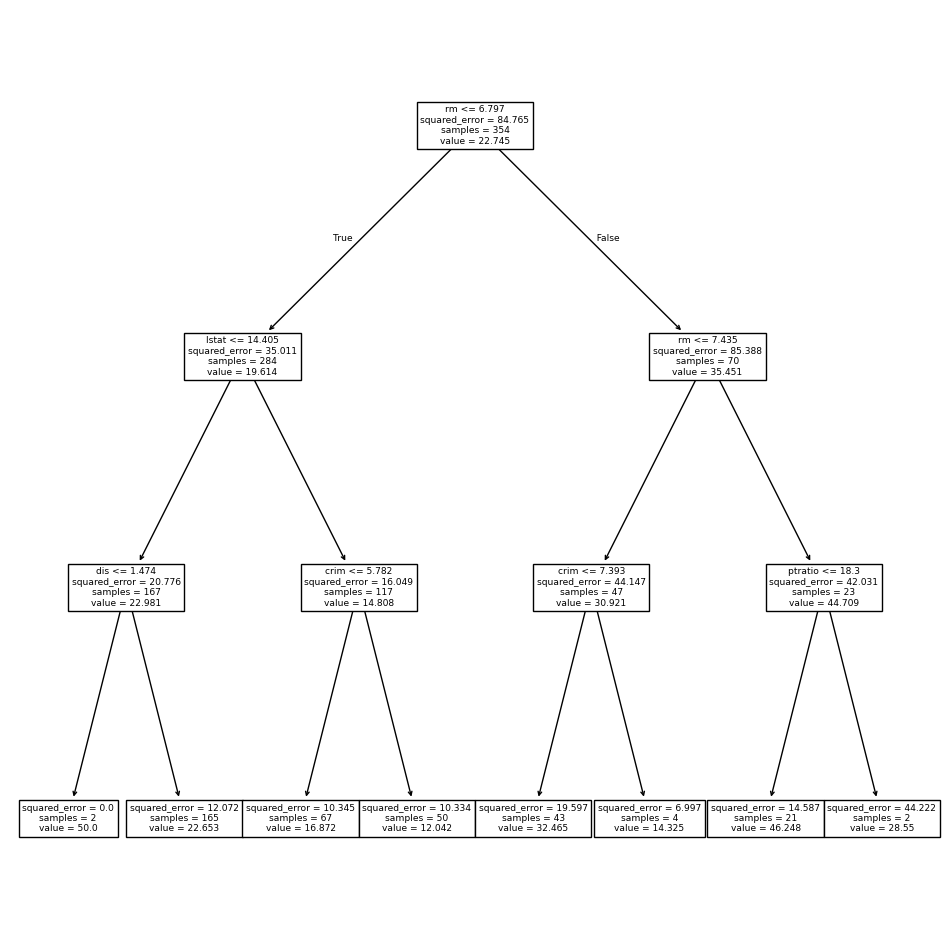

In [39]:
reg = DTR(max_depth=3)
reg.fit(X_train , y_train)
ax = subplots(figsize=(12,12))[1]
plot_tree(reg ,
            feature_names=feature_names ,
            ax=ax);

In [41]:
ccp_path = reg.cost_complexity_pruning_path(X_train , y_train)
kfold = skm.KFold(5,
                shuffle=True ,
                random_state =10)
grid = skm.GridSearchCV(reg ,
                        {'ccp_alpha': ccp_path.ccp_alphas},
                        refit=True ,
                        cv=kfold ,
                        scoring='neg_mean_squared_error')
G = grid.fit(X_train, y_train)

In [43]:
best_ = grid.best_estimator_
np.mean((y_test - best_.predict(X_test))**2)

28.06985754975404

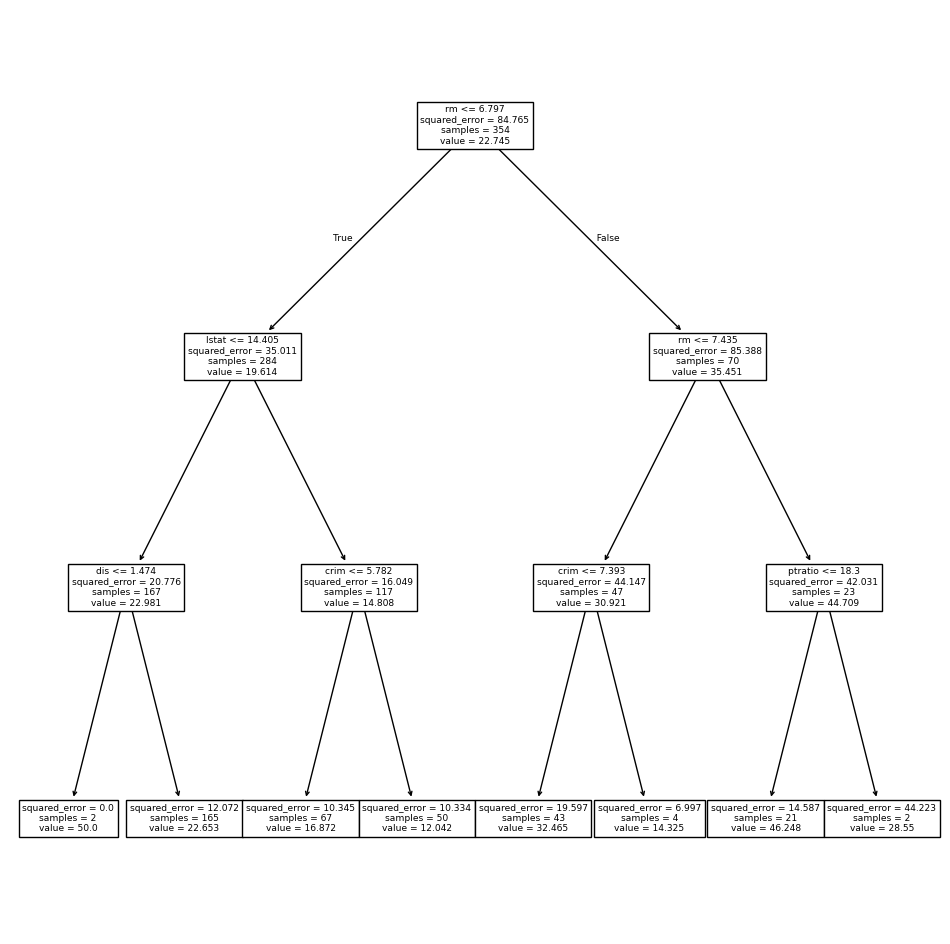

In [45]:
ax = subplots(figsize=(12,12))[1]
plot_tree(G.best_estimator_ ,
        feature_names=feature_names ,
        ax=ax);

## Bagging and Radom forest

In [47]:
bag_boston = RF(max_features=X_train.shape[1], random_state=0)
bag_boston.fit(X_train , y_train)

RandomForestRegressor(max_features=12, random_state=0)

14.634700151315787

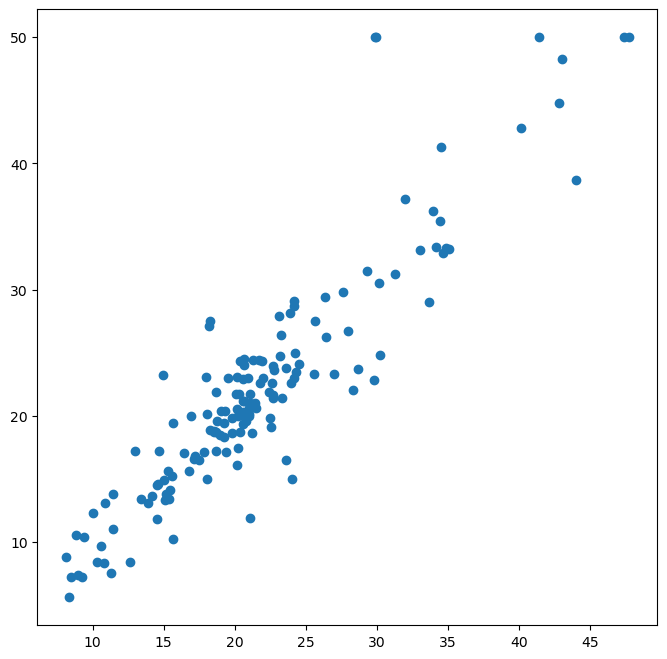

In [49]:
ax = subplots(figsize=(8,8))[1]
y_hat_bag = bag_boston.predict(X_test)
ax.scatter(y_hat_bag , y_test)
np.mean((y_test - y_hat_bag)**2)

In [51]:
bag_boston = RF(max_features=X_train.shape[1],
            n_estimators=500,
            random_state=0).fit(X_train , y_train)
y_hat_bag = bag_boston.predict(X_test)
np.mean((y_test - y_hat_bag)**2)

14.605662565263161

In [53]:
RF_boston = RF(max_features=6,
                random_state=0).fit(X_train , y_train)
y_hat_RF = RF_boston.predict(X_test)
np.mean((y_test - y_hat_RF)**2)

20.04276446710527

In [55]:
feature_imp = pd.DataFrame(
    {'importance':RF_boston.feature_importances_},
    index=feature_names)
feature_imp.sort_values(by='importance', ascending=False)

,importance
lstat,0.356203
rm,0.332163
ptratio,0.067270
crim,0.055404
indus,0.053851
dis,0.041582
nox,0.035225
tax,0.025355
age,0.021506
rad,0.004784


## Boosting

In [57]:
boost_boston = GBR(n_estimators=5000,
                learning_rate =0.001,
                max_depth=3,
                random_state=0)
boost_boston.fit(X_train , y_train)

GradientBoostingRegressor(learning_rate=0.001, n_estimators=5000,
                          random_state=0)

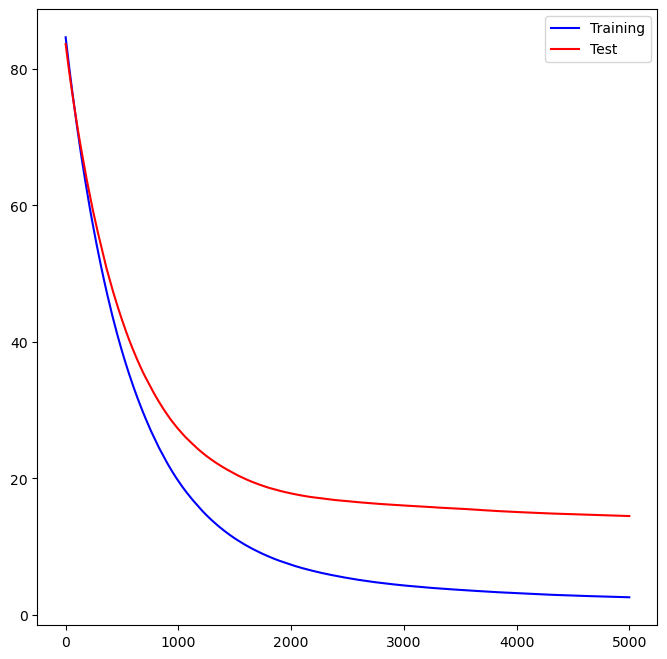

In [59]:
test_error = np.zeros_like(boost_boston.train_score_)
for idx , y_ in enumerate(boost_boston.staged_predict(X_test)):
    test_error[idx] = np.mean((y_test - y_)**2)
plot_idx = np.arange(boost_boston.train_score_.shape[0])
ax = subplots(figsize=(8,8))[1]
ax.plot(plot_idx ,
        boost_boston.train_score_ ,
        'b',
        label='Training')
ax.plot(plot_idx ,
        test_error ,
        'r',
        label='Test')
ax.legend();

In [61]:
y_hat_boost = boost_boston.predict(X_test);
np.mean((y_test - y_hat_boost)**2)

14.481405918831591

In [63]:
boost_boston = GBR(n_estimators=5000,
                    learning_rate=0.2,
                    max_depth=3,
                    random_state=0)
boost_boston.fit(X_train ,
                y_train)
y_hat_boost = boost_boston.predict(X_test);
np.mean((y_test - y_hat_boost)**2)

14.501514553719565

## Bayesian additive regression tree

In [65]:
bart_boston = BART(random_state=0, burnin=5, ndraw=15)
bart_boston.fit(X_train , y_train)

BART(burnin=5, ndraw=15, random_state=0)

In [66]:
yhat_test = bart_boston.predict(X_test.astype(np.float32))
np.mean((y_test - yhat_test)**2)

22.145009458109232

In [69]:
var_inclusion = pd.Series(bart_boston.variable_inclusion_.mean(0),
                            index=D.columns)
var_inclusion

crim       26.933333
zn         27.866667
indus      26.466667
chas       22.466667
nox        26.600000
rm         29.800000
age        22.733333
dis        26.466667
rad        23.666667
tax        24.133333
ptratio    24.266667
lstat      31.000000
dtype: float64